<a href="https://colab.research.google.com/github/Shreyas-Hegde10/MNIST-Deep-Learning/blob/main/Image_Classification_Using_a_Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import optuna
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Loading Dataset

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 33311735.82it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 956339.46it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8983847.26it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2801548.35it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Viewing Samples

image.shape: torch.Size([1, 28, 28])
Label: 5


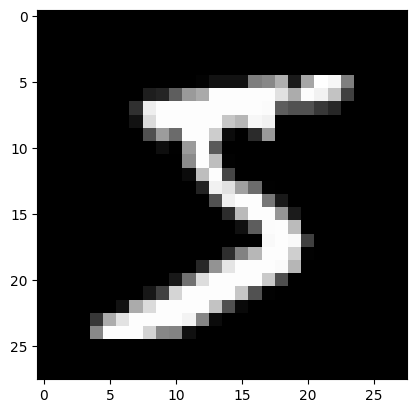

In [ ]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

Creating Training and Validation Steps

In [ ]:
val_size = 10000
test_size = 5000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(len(train_ds),len(val_ds), len(test_ds))

45000 10000 5000


In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape:  torch.Size([128, 1, 28, 28])
grid.shape:  torch.Size([3, 242, 482])


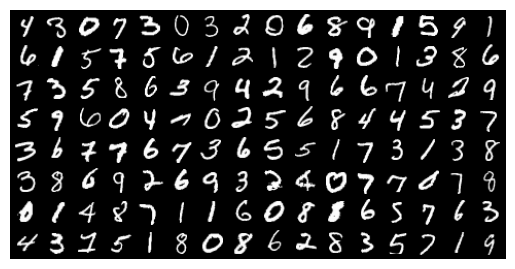

In [ ]:
# Visualizing some samples from the training set
for images,_ in train_loader:
    print('images.shape: ', images.shape)
    print('grid.shape: ', make_grid(images, nrow=16).shape)
    plt.axis('off')
    plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break


In [ ]:
#Flattening images into vectors of size 784
for images,labels in train_loader:
    print('images.shape: ', images.shape)
    inputs = images.reshape(-1,784)
    print('inputs.shape: ', inputs.shape)
    break

images.shape:  torch.Size([128, 1, 28, 28])
inputs.shape:  torch.Size([128, 784])


Creating A Hidden Layer

In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32
layer1 = nn.Linear(input_size,hidden_size)# Input: input_size, Output: hidden_size

In [ ]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape: ', layer1_outputs.shape)

layer1_outputs.shape:  torch.Size([128, 32])


Activation function

In [ ]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6961444616317749
min(relu_outputs): 0.0


Output Layer

In [ ]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size) # Input: hidden_size, Output: output_size
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [ ]:
# Computing loss
F.cross_entropy(layer2_outputs, labels)

tensor(2.3108, grad_fn=<NllLossBackward0>)

Creating Model

In [ ]:
class MnistModel(nn.Module):
    # Class constructor
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    # Forward pass method
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    # Training method
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    # Validation loss and accuracy method
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    # Method used for combining batch losses & accuracies into epoch losses/accuracies
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # Method used for format validation losses and accuracies
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

    # Test loss and accuracy method
    def test_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss, 'test_acc': acc}

    # Method used for combining batch losses & accuracies into epoch losses/accuracies for the test set
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    # Method used for format test losses and accuracies
    def epoch_endtest(self, epoch, result):
        print("Epoch [{}], test_loss: {:.4f}, test_acc: {:.4f}".format(epoch, result['test_loss'], result['test_acc']))

In [ ]:
# Accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels)/len(preds))


In [ ]:
# Creating a model
input_size = 784
hidden_size = 32
num_classes = 10

In [ ]:
model = MnistModel(input_size, hidden_size,num_classes)

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)


Loss: 2.3111283779144287
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0547, -0.2143, -0.1108, -0.0752, -0.0663, -0.0441,  0.0740, -0.1205,
          0.1508,  0.0077],
        [ 0.0096, -0.2007, -0.1938, -0.0218, -0.0348, -0.0946,  0.1004, -0.1443,
          0.0715,  0.1087]])


Using a GPU

In [ ]:
# Checking if NVIDIA CUDA drivers are installed and if GPU is available
torch.cuda.is_available() # True

# Function to check if GPUs are available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(device)


cuda


In [ ]:
# Definining a function that can move data and model to a chosen device
def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# Creating a class to wrap existing data loaders and move data batches to selected device
class DeviceDataLoader():
    # Class constructor
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device

    # Method used to yield a batch of data after moving to a device
    def __iter__(self):
        for b in self.data_loader:
            yield to_device(b, self.device)

    # Creating a method to find number of batches
    def __len__(self):
        return len(self.data_loader)

In [ ]:
# Wrapping data loaders using previous class
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
# Checking if tensors have moved to the GPU device
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

# Successfully moved to GPU device

xb.device: cuda:0
yb: tensor([4, 5, 7, 0, 4, 3, 2, 6, 9, 8, 4, 9, 8, 0, 9, 4, 4, 2, 3, 3, 3, 7, 4, 1,
        4, 4, 9, 4, 8, 6, 6, 3, 4, 4, 8, 8, 5, 2, 8, 5, 6, 9, 0, 2, 3, 0, 6, 6,
        2, 1, 3, 4, 4, 3, 5, 4, 1, 6, 1, 1, 0, 6, 6, 8, 2, 5, 2, 3, 9, 3, 8, 1,
        9, 5, 6, 4, 1, 3, 3, 0, 6, 6, 2, 3, 7, 7, 2, 6, 8, 2, 6, 6, 8, 3, 5, 1,
        6, 7, 6, 3, 2, 9, 6, 8, 2, 6, 2, 4, 9, 0, 4, 3, 1, 7, 7, 0, 3, 8, 6, 6,
        1, 0, 4, 7, 1, 3, 1, 9, 6, 3, 2, 8, 3, 3, 6, 2, 7, 8, 5, 3, 1, 4, 1, 0,
        8, 5, 5, 0, 0, 5, 9, 7, 5, 4, 0, 3, 2, 9, 1, 4, 0, 6, 9, 8, 3, 8, 5, 7,
        3, 3, 9, 5, 2, 7, 9, 2, 8, 5, 6, 6, 1, 6, 4, 3, 8, 8, 4, 0, 2, 6, 8, 9,
        7, 3, 7, 9, 5, 0, 4, 0, 5, 2, 6, 8, 0, 2, 2, 0, 1, 2, 8, 2, 6, 6, 8, 4,
        7, 5, 2, 3, 6, 1, 4, 6, 2, 5, 7, 6, 7, 5, 7, 2, 4, 6, 7, 8, 1, 0, 5, 9,
        2, 3, 1, 3, 6, 0, 7, 7, 5, 3, 3, 7, 9, 2, 8, 8], device='cuda:0')


Training the Model

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader,opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
# Model (on GPU)
model_gpu = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model_gpu, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history1 = fit(5, 0.5, model_gpu, train_loader, val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.2666, val_acc: 0.9230
Epoch [1], val_loss: 0.2423, val_acc: 0.9285
Epoch [2], val_loss: 0.1846, val_acc: 0.9448
Epoch [3], val_loss: 0.1635, val_acc: 0.9525
Epoch [4], val_loss: 0.1666, val_acc: 0.9526


In [ ]:
history2 = fit(5, 0.5, model_gpu, train_loader, val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1494, val_acc: 0.9582
Epoch [1], val_loss: 0.1365, val_acc: 0.9605
Epoch [2], val_loss: 0.1395, val_acc: 0.9610
Epoch [3], val_loss: 0.1725, val_acc: 0.9496
Epoch [4], val_loss: 0.1478, val_acc: 0.9578


In [ ]:
history3 = fit(5, 0.5, model_gpu, train_loader, val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1591, val_acc: 0.9549
Epoch [1], val_loss: 0.1430, val_acc: 0.9590
Epoch [2], val_loss: 0.1389, val_acc: 0.9611
Epoch [3], val_loss: 0.1357, val_acc: 0.9630
Epoch [4], val_loss: 0.1601, val_acc: 0.9549


In [ ]:
history4 = fit(5, 0.1, model_gpu, train_loader, val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1235, val_acc: 0.9665
Epoch [1], val_loss: 0.1218, val_acc: 0.9675
Epoch [2], val_loss: 0.1232, val_acc: 0.9669
Epoch [3], val_loss: 0.1245, val_acc: 0.9661
Epoch [4], val_loss: 0.1227, val_acc: 0.9672


In [ ]:
history5 = fit(5, 0.1, model_gpu, train_loader, val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1248, val_acc: 0.9674
Epoch [1], val_loss: 0.1231, val_acc: 0.9674
Epoch [2], val_loss: 0.1240, val_acc: 0.9672
Epoch [3], val_loss: 0.1243, val_acc: 0.9673
Epoch [4], val_loss: 0.1244, val_acc: 0.9667


Text(0.5, 1.0, 'Accuracy Compared To # of Epochs')

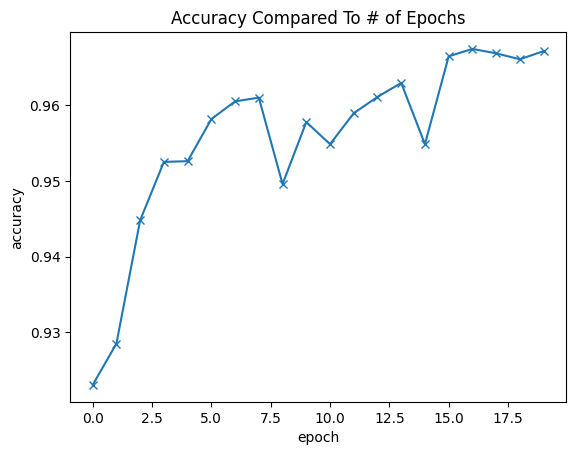

In [ ]:
history = history1+history2+history3+history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Compared To # of Epochs')

Hyperparameter Optimization

In [ ]:
#Defining objective function
def objective(trial):

    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('lr', 1e-1, 1e-0)

    # Creating the model
    model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
    to_device(model, device)

    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train and val loaders
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=256)
    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)


    num_epochs = 5
    for epoch in range(num_epochs):
        for batch in train_loader:

             # Training Loop
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation Stage
        result = evaluate(model, val_loader)

    return result['val_acc']



In [ ]:
# Create a study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Number of trials

# Get the best trial
best_trial = study.best_trial

# Print the best hyperparameters, best accuracy, and trial number
print(f"Best hyperparameters: {best_trial.params}")
print(f"Best test accuracy: {best_trial.value:.4f}")
print(f"Trial number with best test accuracy: {best_trial.number}")

[I 2024-09-01 16:01:59,783] A new study created in memory with name: no-name-154dbd09-6a1d-4eb7-b2c5-6ad3aaceecd0
/tmp/ipykernel_36/521537397.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-1, 1e-0)
/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))
[I 2024-09-01 16:02:31,354] Trial 0 finished with value: 0.9400390982627869 and parameters: {'lr': 0.8739981112679784}. Best is trial 0 with value: 0.9400390982627869.
[I 2024-09-01 16:03:02,864] Trial 1 finished with value: 0.954882800579071 and parameters: {'lr': 0.8313930555502905}. Best is t

Best hyperparameters: {'lr': 0.5840831129446328}
Best test accuracy: 0.9561
Trial number with best test accuracy: 2


In [ ]:
{'lr': 0.0178878518656460}
{'lr': 0.09833396206168134}
{'lr': 0.5082839076857731}
{'lr': 0.5840831129446328}

{'lr': 0.5082839076857731}

In [ ]:
m1 = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(m1, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
m1_history1 = fit(5,0.0178878518656460,m1,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.8579, val_acc: 0.8234
Epoch [1], val_loss: 0.5437, val_acc: 0.8651
Epoch [2], val_loss: 0.4527, val_acc: 0.8800
Epoch [3], val_loss: 0.4087, val_acc: 0.8880
Epoch [4], val_loss: 0.3830, val_acc: 0.8936


In [ ]:
m1_history2 = fit(5,0.0178878518656460,m1,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.3669, val_acc: 0.8981
Epoch [1], val_loss: 0.3519, val_acc: 0.9007
Epoch [2], val_loss: 0.3408, val_acc: 0.9048
Epoch [3], val_loss: 0.3335, val_acc: 0.9055
Epoch [4], val_loss: 0.3252, val_acc: 0.9084


In [ ]:
m1_history3 = fit(5,0.0178878518656460,m1,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.3152, val_acc: 0.9093
Epoch [1], val_loss: 0.3100, val_acc: 0.9112
Epoch [2], val_loss: 0.3028, val_acc: 0.9141
Epoch [3], val_loss: 0.2970, val_acc: 0.9135
Epoch [4], val_loss: 0.2913, val_acc: 0.9156


In [ ]:
m1_history4 = fit(5,0.0178878518656460,m1,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.2865, val_acc: 0.9172
Epoch [1], val_loss: 0.2802, val_acc: 0.9194
Epoch [2], val_loss: 0.2765, val_acc: 0.9205
Epoch [3], val_loss: 0.2723, val_acc: 0.9208
Epoch [4], val_loss: 0.2675, val_acc: 0.9230


In [ ]:
m2 = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(m2, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
m2_history1 = fit(5,0.09833396206168134,m2,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.3886, val_acc: 0.8895
Epoch [1], val_loss: 0.3388, val_acc: 0.9035
Epoch [2], val_loss: 0.3000, val_acc: 0.9146
Epoch [3], val_loss: 0.2736, val_acc: 0.9218
Epoch [4], val_loss: 0.2544, val_acc: 0.9273


In [ ]:
m2_history2 = fit(5,0.09833396206168134,m2,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.2373, val_acc: 0.9311
Epoch [1], val_loss: 0.2255, val_acc: 0.9330
Epoch [2], val_loss: 0.2093, val_acc: 0.9408
Epoch [3], val_loss: 0.2045, val_acc: 0.9425
Epoch [4], val_loss: 0.1956, val_acc: 0.9436


In [ ]:
m2_history3 = fit(5,0.09833396206168134,m2,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1875, val_acc: 0.9471
Epoch [1], val_loss: 0.1790, val_acc: 0.9489
Epoch [2], val_loss: 0.1729, val_acc: 0.9519
Epoch [3], val_loss: 0.1691, val_acc: 0.9516
Epoch [4], val_loss: 0.1657, val_acc: 0.9535


In [ ]:
m2_history4 = fit(5,0.09833396206168134,m2,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1609, val_acc: 0.9536
Epoch [1], val_loss: 0.1572, val_acc: 0.9563
Epoch [2], val_loss: 0.1561, val_acc: 0.9545
Epoch [3], val_loss: 0.1530, val_acc: 0.9571
Epoch [4], val_loss: 0.1499, val_acc: 0.9582


In [ ]:
m3 = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(m3, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
m3_history1 = fit(5,0.5082839076857731,m3,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.2544, val_acc: 0.9212
Epoch [1], val_loss: 0.2026, val_acc: 0.9413
Epoch [2], val_loss: 0.1906, val_acc: 0.9439
Epoch [3], val_loss: 0.1520, val_acc: 0.9572
Epoch [4], val_loss: 0.1413, val_acc: 0.9586


In [ ]:
m3_history2 = fit(5,0.5082839076857731,m3,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1625, val_acc: 0.9523
Epoch [1], val_loss: 0.1474, val_acc: 0.9583
Epoch [2], val_loss: 0.1484, val_acc: 0.9591
Epoch [3], val_loss: 0.1372, val_acc: 0.9624
Epoch [4], val_loss: 0.1439, val_acc: 0.9611


In [ ]:
m3_history3 = fit(5,0.5082839076857731,m3,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1586, val_acc: 0.9548
Epoch [1], val_loss: 0.1314, val_acc: 0.9662
Epoch [2], val_loss: 0.1413, val_acc: 0.9620
Epoch [3], val_loss: 0.1521, val_acc: 0.9596
Epoch [4], val_loss: 0.1372, val_acc: 0.9615


In [ ]:
m3_history4 = fit(5,0.5082839076857731,m3,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1460, val_acc: 0.9623
Epoch [1], val_loss: 0.1480, val_acc: 0.9613
Epoch [2], val_loss: 0.1600, val_acc: 0.9594
Epoch [3], val_loss: 0.1651, val_acc: 0.9589
Epoch [4], val_loss: 0.1557, val_acc: 0.9591


In [ ]:
m4 = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(m4, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
m4_history1 = fit(5,0.5840831129446328,m4,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.2300, val_acc: 0.9329
Epoch [1], val_loss: 0.2107, val_acc: 0.9389
Epoch [2], val_loss: 0.1572, val_acc: 0.9547
Epoch [3], val_loss: 0.1619, val_acc: 0.9512
Epoch [4], val_loss: 0.1439, val_acc: 0.9568


In [ ]:
m4_history2 = fit(5,0.5840831129446328,m4,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1381, val_acc: 0.9590
Epoch [1], val_loss: 0.1375, val_acc: 0.9598
Epoch [2], val_loss: 0.1383, val_acc: 0.9591
Epoch [3], val_loss: 0.1657, val_acc: 0.9510
Epoch [4], val_loss: 0.1400, val_acc: 0.9595


In [ ]:
m4_history3 = fit(5,0.5840831129446328,m4,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1415, val_acc: 0.9604
Epoch [1], val_loss: 0.1501, val_acc: 0.9599
Epoch [2], val_loss: 0.1319, val_acc: 0.9646
Epoch [3], val_loss: 0.1472, val_acc: 0.9596
Epoch [4], val_loss: 0.1337, val_acc: 0.9645


In [ ]:
m4_history4 = fit(5,0.5840831129446328,m4,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1410, val_acc: 0.9621
Epoch [1], val_loss: 0.1747, val_acc: 0.9554
Epoch [2], val_loss: 0.1471, val_acc: 0.9642
Epoch [3], val_loss: 0.1416, val_acc: 0.9646
Epoch [4], val_loss: 0.1527, val_acc: 0.9622


In [ ]:
m1_history5 = fit(30,0.0178878518656460,m1,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.2627, val_acc: 0.9255
Epoch [1], val_loss: 0.2588, val_acc: 0.9250
Epoch [2], val_loss: 0.2554, val_acc: 0.9255
Epoch [3], val_loss: 0.2515, val_acc: 0.9272
Epoch [4], val_loss: 0.2487, val_acc: 0.9293
Epoch [5], val_loss: 0.2446, val_acc: 0.9314
Epoch [6], val_loss: 0.2409, val_acc: 0.9312
Epoch [7], val_loss: 0.2396, val_acc: 0.9339
Epoch [8], val_loss: 0.2354, val_acc: 0.9319
Epoch [9], val_loss: 0.2337, val_acc: 0.9344
Epoch [10], val_loss: 0.2302, val_acc: 0.9363
Epoch [11], val_loss: 0.2280, val_acc: 0.9370
Epoch [12], val_loss: 0.2258, val_acc: 0.9377
Epoch [13], val_loss: 0.2227, val_acc: 0.9389
Epoch [14], val_loss: 0.2206, val_acc: 0.9389
Epoch [15], val_loss: 0.2196, val_acc: 0.9386
Epoch [16], val_loss: 0.2175, val_acc: 0.9401
Epoch [17], val_loss: 0.2152, val_acc: 0.9414
Epoch [18], val_loss: 0.2126, val_acc: 0.9410
Epoch [19], val_loss: 0.2105, val_acc: 0.9416
Epoch [20], val_loss: 0.2082, val_acc: 0.9427
Epoch [21], val_loss: 0.2063, val_acc: 0.943

In [ ]:
m2_history5 = fit(30,0.09833396206168134,m2,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1507, val_acc: 0.9581
Epoch [1], val_loss: 0.1456, val_acc: 0.9592
Epoch [2], val_loss: 0.1459, val_acc: 0.9585
Epoch [3], val_loss: 0.1538, val_acc: 0.9561
Epoch [4], val_loss: 0.1447, val_acc: 0.9590
Epoch [5], val_loss: 0.1424, val_acc: 0.9590
Epoch [6], val_loss: 0.1418, val_acc: 0.9590
Epoch [7], val_loss: 0.1476, val_acc: 0.9570
Epoch [8], val_loss: 0.1398, val_acc: 0.9608
Epoch [9], val_loss: 0.1365, val_acc: 0.9604
Epoch [10], val_loss: 0.1355, val_acc: 0.9614
Epoch [11], val_loss: 0.1384, val_acc: 0.9595
Epoch [12], val_loss: 0.1341, val_acc: 0.9617
Epoch [13], val_loss: 0.1360, val_acc: 0.9608
Epoch [14], val_loss: 0.1357, val_acc: 0.9608
Epoch [15], val_loss: 0.1336, val_acc: 0.9615
Epoch [16], val_loss: 0.1360, val_acc: 0.9627
Epoch [17], val_loss: 0.1373, val_acc: 0.9601
Epoch [18], val_loss: 0.1332, val_acc: 0.9623
Epoch [19], val_loss: 0.1329, val_acc: 0.9621
Epoch [20], val_loss: 0.1339, val_acc: 0.9623
Epoch [21], val_loss: 0.1321, val_acc: 0.961

In [ ]:
m3_history5 = fit(30,0.5082839076857731,m3,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1938, val_acc: 0.9530
Epoch [1], val_loss: 0.1582, val_acc: 0.9604
Epoch [2], val_loss: 0.1586, val_acc: 0.9589
Epoch [3], val_loss: 0.1788, val_acc: 0.9571
Epoch [4], val_loss: 0.1517, val_acc: 0.9628
Epoch [5], val_loss: 0.1599, val_acc: 0.9610
Epoch [6], val_loss: 0.1888, val_acc: 0.9574
Epoch [7], val_loss: 0.1558, val_acc: 0.9643
Epoch [8], val_loss: 0.1725, val_acc: 0.9604
Epoch [9], val_loss: 0.1685, val_acc: 0.9607
Epoch [10], val_loss: 0.1940, val_acc: 0.9562
Epoch [11], val_loss: 0.1809, val_acc: 0.9585
Epoch [12], val_loss: 0.1749, val_acc: 0.9594
Epoch [13], val_loss: 0.1786, val_acc: 0.9629
Epoch [14], val_loss: 0.1724, val_acc: 0.9621
Epoch [15], val_loss: 0.1813, val_acc: 0.9588
Epoch [16], val_loss: 0.1776, val_acc: 0.9611
Epoch [17], val_loss: 0.1796, val_acc: 0.9633
Epoch [18], val_loss: 0.1843, val_acc: 0.9616
Epoch [19], val_loss: 0.1859, val_acc: 0.9623
Epoch [20], val_loss: 0.1842, val_acc: 0.9621
Epoch [21], val_loss: 0.2068, val_acc: 0.958

In [ ]:
m4_history5 = fit(30,0.5840831129446328,m4,train_loader,val_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], val_loss: 0.1421, val_acc: 0.9653
Epoch [1], val_loss: 0.1445, val_acc: 0.9649
Epoch [2], val_loss: 0.1470, val_acc: 0.9641
Epoch [3], val_loss: 0.1661, val_acc: 0.9584
Epoch [4], val_loss: 0.1630, val_acc: 0.9625
Epoch [5], val_loss: 0.1608, val_acc: 0.9633
Epoch [6], val_loss: 0.1585, val_acc: 0.9641
Epoch [7], val_loss: 0.1854, val_acc: 0.9563
Epoch [8], val_loss: 0.1823, val_acc: 0.9604
Epoch [9], val_loss: 0.1718, val_acc: 0.9645
Epoch [10], val_loss: 0.1721, val_acc: 0.9641
Epoch [11], val_loss: 0.1636, val_acc: 0.9652
Epoch [12], val_loss: 0.1845, val_acc: 0.9594
Epoch [13], val_loss: 0.1669, val_acc: 0.9665
Epoch [14], val_loss: 0.1845, val_acc: 0.9634
Epoch [15], val_loss: 0.1957, val_acc: 0.9611
Epoch [16], val_loss: 0.1740, val_acc: 0.9637
Epoch [17], val_loss: 0.1781, val_acc: 0.9643
Epoch [18], val_loss: 0.1751, val_acc: 0.9657
Epoch [19], val_loss: 0.1985, val_acc: 0.9618
Epoch [20], val_loss: 0.1750, val_acc: 0.9651
Epoch [21], val_loss: 0.1792, val_acc: 0.965

Text(0.5, 1.0, 'Accuracy Compared To # of Epochs')

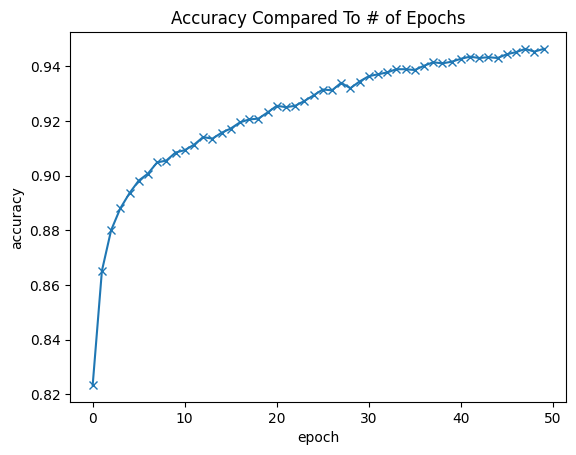

In [ ]:
history = m1_history1 +m1_history2 +m1_history3 +m1_history4 + m1_history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Compared To # of Epochs')

Text(0.5, 1.0, 'Accuracy Compared To # of Epochs')

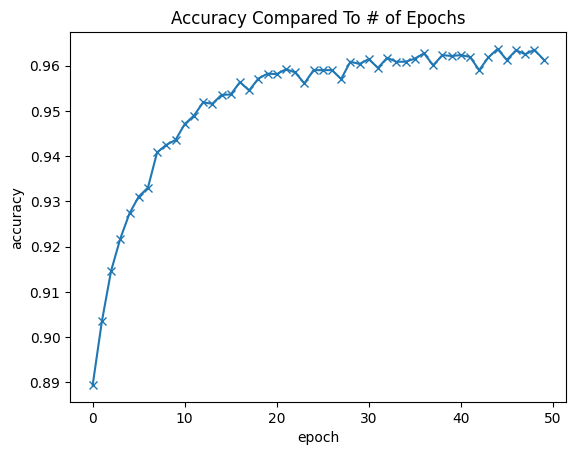

In [ ]:
history = m2_history1 +m2_history2 +m2_history3 +m2_history4 + m2_history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Compared To # of Epochs')

Text(0.5, 1.0, 'Accuracy Compared To # of Epochs')

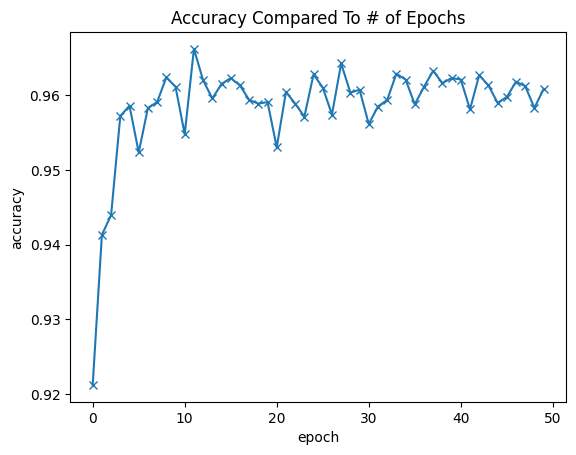

In [ ]:
history = m3_history1 +m3_history2 +m3_history3 +m3_history4 + m3_history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Compared To # of Epochs')

Text(0.5, 1.0, 'Accuracy Compared To # of Epochs')

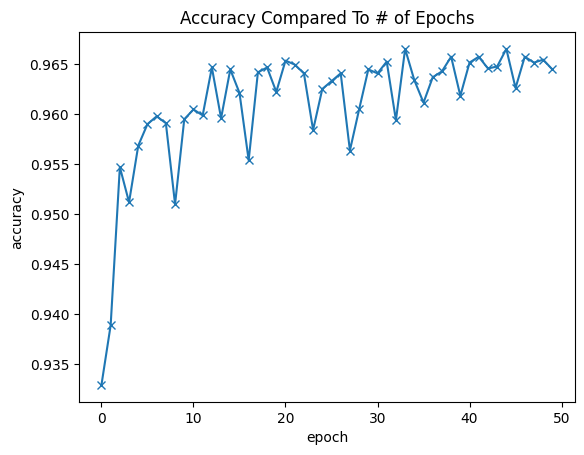

In [ ]:
history = m4_history1 +m4_history2 +m4_history3 +m4_history4 + m4_history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Compared To # of Epochs')

Test Set Results

In [ ]:
def test_evaluate(model, test_loader):
    """Evaluate the model's performance on the test set"""
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

def test_fit(epochs, lr, model, train_loader, test_loader,opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = test_evaluate(model, test_loader)
        model.epoch_endtest(epoch, result)
        history.append(result)
    return history

In [ ]:
test_fit(5,0.1,model_gpu,train_loader,test_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], test_loss: 0.1205, test_acc: 0.9671
Epoch [1], test_loss: 0.1204, test_acc: 0.9662
Epoch [2], test_loss: 0.1203, test_acc: 0.9663
Epoch [3], test_loss: 0.1208, test_acc: 0.9656
Epoch [4], test_loss: 0.1198, test_acc: 0.9665


[{'test_loss': 0.12047938257455826, 'test_acc': 0.9671301245689392},
 {'test_loss': 0.12040393799543381, 'test_acc': 0.9661535620689392},
 {'test_loss': 0.12032432854175568, 'test_acc': 0.9663488268852234},
 {'test_loss': 0.12075672298669815, 'test_acc': 0.9655675888061523},
 {'test_loss': 0.11975502222776413, 'test_acc': 0.9665441513061523}]

In [ ]:
test_fit(5,0.0178878518656460,m1,train_loader,test_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], test_loss: 0.1851, test_acc: 0.9506
Epoch [1], test_loss: 0.1822, test_acc: 0.9504
Epoch [2], test_loss: 0.1812, test_acc: 0.9523
Epoch [3], test_loss: 0.1804, test_acc: 0.9519
Epoch [4], test_loss: 0.1801, test_acc: 0.9515


[{'test_loss': 0.18507523834705353, 'test_acc': 0.950551450252533},
 {'test_loss': 0.18220466375350952, 'test_acc': 0.950356125831604},
 {'test_loss': 0.18115633726119995, 'test_acc': 0.952309250831604},
 {'test_loss': 0.18039055168628693, 'test_acc': 0.9519186019897461},
 {'test_loss': 0.18011541664600372, 'test_acc': 0.951528012752533}]

In [ ]:
test_fit(5,0.09833396206168134,m2,train_loader,test_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], test_loss: 0.1205, test_acc: 0.9638
Epoch [1], test_loss: 0.1208, test_acc: 0.9642
Epoch [2], test_loss: 0.1175, test_acc: 0.9669
Epoch [3], test_loss: 0.1229, test_acc: 0.9659
Epoch [4], test_loss: 0.1181, test_acc: 0.9657


[{'test_loss': 0.12046798318624496, 'test_acc': 0.9638097882270813},
 {'test_loss': 0.12082470953464508, 'test_acc': 0.9641774296760559},
 {'test_loss': 0.11753547191619873, 'test_acc': 0.9668658375740051},
 {'test_loss': 0.12285073101520538, 'test_acc': 0.9659122824668884},
 {'test_loss': 0.1180553212761879, 'test_acc': 0.9657169580459595}]

In [ ]:
test_fit(5,0.5082839076857731,m3,train_loader,test_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], test_loss: 0.1925, test_acc: 0.9636
Epoch [1], test_loss: 0.1968, test_acc: 0.9622
Epoch [2], test_loss: 0.1973, test_acc: 0.9638
Epoch [3], test_loss: 0.1991, test_acc: 0.9628
Epoch [4], test_loss: 0.1989, test_acc: 0.9630


[{'test_loss': 0.19245773553848267, 'test_acc': 0.9635915160179138},
 {'test_loss': 0.1967972368001938, 'test_acc': 0.9622243046760559},
 {'test_loss': 0.1972833126783371, 'test_acc': 0.9637638330459595},
 {'test_loss': 0.1991051882505417, 'test_acc': 0.962810218334198},
 {'test_loss': 0.19891534745693207, 'test_acc': 0.963005542755127}]

In [ ]:
test_fit(5,0.5840831129446328,m4,train_loader,test_loader)

/tmp/ipykernel_36/55389227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.sum(preds == labels)/len(preds))


Epoch [0], test_loss: 0.1739, test_acc: 0.9642
Epoch [1], test_loss: 0.1730, test_acc: 0.9649
Epoch [2], test_loss: 0.1758, test_acc: 0.9643
Epoch [3], test_loss: 0.1739, test_acc: 0.9645
Epoch [4], test_loss: 0.1776, test_acc: 0.9636


[{'test_loss': 0.1739061176776886, 'test_acc': 0.9641544222831726},
 {'test_loss': 0.1729913204908371, 'test_acc': 0.9649357199668884},
 {'test_loss': 0.17578616738319397, 'test_acc': 0.964326798915863},
 {'test_loss': 0.17394772171974182, 'test_acc': 0.9645450711250305},
 {'test_loss': 0.1776454746723175, 'test_acc': 0.9635685086250305}]